Test performansı:
 RMSE: 3.3140
 MAE : 2.8631
 MAPE (%): 3.47


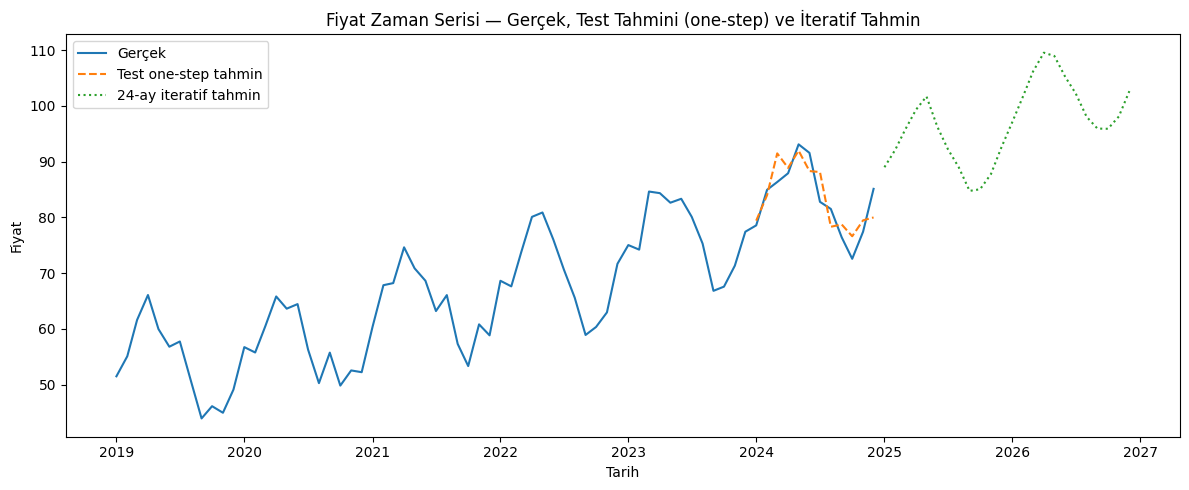

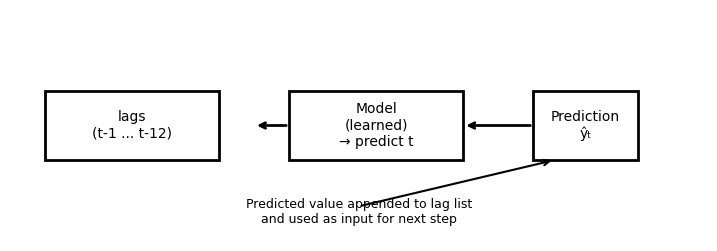


Kaydedilen dosyalar (outputs klasörü):
total 176
drwxr-xr-x   6 nurdanaydogdu  staff    192 14 Kas 12:58 .
drwxr-x---+ 75 nurdanaydogdu  staff   2400 14 Kas 12:58 ..
-rw-r--r--   1 nurdanaydogdu  staff    708 14 Kas 12:58 24mo_forecast.csv
-rw-r--r--   1 nurdanaydogdu  staff  16631 14 Kas 12:58 iterative_schematic.png
-rw-r--r--   1 nurdanaydogdu  staff  60400 14 Kas 12:58 price_forecast_plot.png
-rw-r--r--   1 nurdanaydogdu  staff    585 14 Kas 12:58 test_results.csv


In [1]:
# Google Colab için tam çalıştırılabilir örnek:
# - Sentetik aylık fiyat serisi oluşturur
# - lag_1..lag_12 özellikleri oluşturur
# - İlk 48 ay eğitim, sonraki 12 ay test (toplam 72 aylık sentetik veri kullanılıyor)
# - LinearRegression ile autoregresif (one-step-ahead) model eğitir
# - Test performansını yazdırır (RMSE, MAE, MAPE)
# - Son 12 aydan başlayarak 24 aylık iteratif tahmin üretir
# - Görselleri ./outputs içine kaydeder ve Colab'ta gösterir
# - İndirilebilir hale getirmek için google.colab.files.download örneği içerir

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime

# ---------- Ayarlar ----------
np.random.seed(42)
periods = 72         # 72 aylık sentetik veri (6 yıl) -> droplag sonrası 60 satır kalacak
max_lag = 12
train_rows_after_dropna = 48  # dropna sonrası kaç satırı train olarak kullanacağımız (48 train, 12 test)
forecast_horizon = 24         # iteratif olarak öngörülecek ay sayısı
output_dir = "./outputs"      # Colab uyumlu çıktı dizini
os.makedirs(output_dir, exist_ok=True)

# ---------- 1) Sentetik veri üretimi ----------
dates = pd.date_range(start="2019-01-01", periods=periods, freq="MS")  # aylık, month start
trend = 0.5 * np.arange(periods)                                      # basit lineer trend
seasonal = 10 * np.sin(2 * np.pi * np.arange(periods) / 12)           # yıllık mevsimsel komponent
noise = np.random.normal(scale=3.0, size=periods)                     # rastgele gürültü
base = 50
prices = base + trend + seasonal + noise
series = pd.Series(prices, index=dates, name="price")

# ---------- 2) Lag özellikleri (1..12) ----------
df = pd.DataFrame(series)
for lag in range(1, max_lag + 1):
    df[f"lag_{lag}"] = df["price"].shift(lag)
df_clean = df.dropna().copy()  # ilk 12 satır kaybolur -> kalan = periods - max_lag

# ---------- 3) Train / Test split ----------
# dropna sonrası toplam satır = periods - max_lag
total_after = df_clean.shape[0]
if train_rows_after_dropna + 12 > total_after:
    raise ValueError("train_rows_after_dropna + 12 (test) exceed available rows after dropna. Adjust periods or train size.")

train = df_clean.iloc[:train_rows_after_dropna]
test = df_clean.iloc[train_rows_after_dropna: train_rows_after_dropna + 12]

X_train = train[[f"lag_{i}" for i in range(1, max_lag + 1)]].values
y_train = train["price"].values
X_test = test[[f"lag_{i}" for i in range(1, max_lag + 1)]].values
y_test = test["price"].values
test_index = test.index

# ---------- 4) Model eğitimi (Linear Regression - autoregresif) ----------
model = LinearRegression()
model.fit(X_train, y_train)

# ---------- 5) One-step-ahead test tahminleri (gerçek lag değerleri ile) ----------
y_pred_test = model.predict(X_test)

# ---------- 6) Performans metrikleri ----------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse_test = math.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mape(y_test, y_pred_test)

print("Test performansı:")
print(f" RMSE: {rmse_test:.4f}")
print(f" MAE : {mae_test:.4f}")
print(f" MAPE (%): {mape_test:.2f}")

# ---------- 7) İteratif 24 aylık forecast ----------
# Son gözlenen max_lag değeri seed olarak al (orijinal serinin son gözlemleri)
last_observed = df["price"].iloc[-max_lag:].values.tolist()  # son 12 gözlem
iter_preds = []
iter_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=forecast_horizon, freq="MS")

seed = last_observed.copy()
for i in range(forecast_horizon):
    # model beklediği sırada (lag_1, lag_2, ..., lag_12) girdi hazırla: [t-1, t-2, ..., t-12]
    x = np.array([seed[-1 - k] for k in range(max_lag)])  # [t-1, t-2, ..., t-12]
    x = x.reshape(1, -1)
    pred = model.predict(x)[0]
    iter_preds.append(pred)
    seed.append(pred)

forecast_series = pd.Series(iter_preds, index=iter_dates, name="forecast")

# ---------- 8) Sonuç tabloları ----------
observed_df = pd.DataFrame({"price": series})
test_results = pd.DataFrame({"actual": y_test, "predicted_one_step": y_pred_test}, index=test_index)
forecast_df = pd.DataFrame({"forecast": iter_preds}, index=iter_dates)

# CSV olarak kaydet (isteğe bağlı)
test_results.to_csv(os.path.join(output_dir, "test_results.csv"), index=True)
forecast_df.to_csv(os.path.join(output_dir, "24mo_forecast.csv"), index=True)

# ---------- 9) Grafik: orijinal seri, test tahminleri (one-step) ve iteratif forecast ----------
plt.figure(figsize=(12,5))
plt.plot(observed_df.index, observed_df["price"], label="Gerçek")
plt.plot(test_results.index, test_results["predicted_one_step"], linestyle='--', label="Test one-step tahmin")
plt.plot(forecast_df.index, forecast_df["forecast"], linestyle=':', label=f"{forecast_horizon}-ay iteratif tahmin")
plt.title("Fiyat Zaman Serisi — Gerçek, Test Tahmini (one-step) ve İteratif Tahmin")
plt.xlabel("Tarih")
plt.ylabel("Fiyat")
plt.legend()
plt.tight_layout()

plot_path = os.path.join(output_dir, "price_forecast_plot.png")
plt.savefig(plot_path)
plt.show()
plt.close()

# ---------- 10) Iterative diagram visual (simple box-arrow diagram) ----------
plt.figure(figsize=(9,3))
ax = plt.gca()
ax.axis('off')
boxes = {
    "lags\n(t-1 ... t-12)": (0.05, 0.35, 0.25, 0.3),
    "Model\n(learned)\n→ predict t": (0.4, 0.35, 0.25, 0.3),
    "Prediction\nŷₜ": (0.75, 0.35, 0.15, 0.3)
}
for txt, (x,y,w,h) in boxes.items():
    rect = plt.Rectangle((x,y), w, h, fill=False, linewidth=2)
    ax.add_patch(rect)
    ax.text(x+w/2, y+h/2, txt, ha='center', va='center', fontsize=10)
ax.annotate('', xy=(0.35, 0.5), xytext=(0.4, 0.5), arrowprops=dict(arrowstyle='->', lw=2))
ax.annotate('', xy=(0.65, 0.5), xytext=(0.75, 0.5), arrowprops=dict(arrowstyle='->', lw=2))
ax.annotate('', xy=(0.78, 0.35), xytext=(0.5, 0.15), arrowprops=dict(arrowstyle='->', lw=1.5))
ax.text(0.5, 0.08, "Predicted value appended to lag list\nand used as input for next step", ha='center', fontsize=9)

schem_path = os.path.join(output_dir, "iterative_schematic.png")
plt.savefig(schem_path, bbox_inches='tight')
plt.show()
plt.close()

print("\nKaydedilen dosyalar (outputs klasörü):")
!ls -la outputs

# ---------- 11) Colab için indirme (isteğe bağlı) ----------
# Eğer indirmek isterseniz, aşağıdaki satırların başındaki yorumu kaldırın:
# from google.colab import files
# files.download(os.path.join(output_dir, "price_forecast_plot.png"))
# files.download(os.path.join(output_dir, "iterative_schematic.png"))
# files.download(os.path.join(output_dir, "test_results.csv"))
# files.download(os.path.join(output_dir, "24mo_forecast.csv"))

# ---------- Ek not ----------
# İsterseniz bu hücreyi çalıştırdıktan sonra outputs içindeki PNG ve CSV dosyalarını Colab sol panelinden
# Files sekmesine tıklayıp görebilir ve indirebilirsiniz.
